# Calibrazione definitivo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, SecondLocator, DateFormatter
import pandas as pd
from scipy.stats import linregress
from scipy.stats import chisquare
from scipy import stats
import math

In [2]:
# file necessari 

files_calibrazione_amb = np.array(['ambiente/dati/cal_g5_z6877_amb.txt', 'ambiente/dati/Cal_G5_Z8900_amb.txt', 'ambiente/dati/Cal_G5_z10923_amb.txt'])
parabola = pd.read_csv('dati/TDA2023_04_18.txt' , sep=';', header=None, comment = '#')

files_calibrazione_n = np.array(['azoto/dati/Cal_g5_z2832_az.txt', 'azoto/dati/Cal_g5_z4450_az.txt', 'azoto/dati/Cal_g5_z4854_az.txt', 'azoto/dati/cal_z5_z6877_az.txt'])

In [3]:
# valori zero_base

zero_base_amb = np.array([6877, 8900, 10923])
zero_base_n = np.array([2832, 4450, 4854, 6877])

## Ambiente

            rad      errore
0  15372.338802   34.648636
1   8385.746711  115.022875
2   1355.633663   26.740879


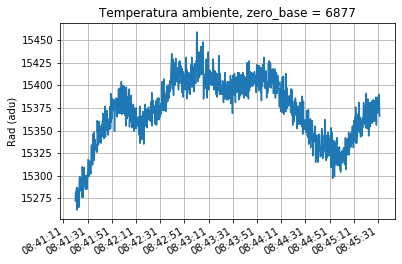

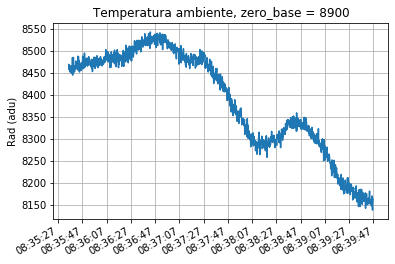

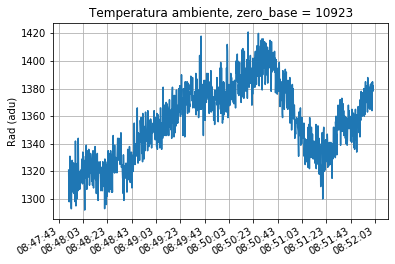

In [11]:
rad_amb = []

for i in range(0,3):
    calibrazione_1 = pd.read_csv (files_calibrazione_amb[i],
                                    sep = ' ',
                                    header=None,
                                    skiprows=10,
                                    decimal='.',
                                    names=['data','ora','rad','temperatura'])
    
    calibrazione_1['data_ora'] = calibrazione_1['data'].map(str) + ' ' + calibrazione_1['ora'].map(str)
    calibrazione_1['data_ora'] = pd.to_datetime(calibrazione_1['data_ora'], format = '%m/%d/%Y %H:%M:%S.%f')
    calibrazione_1 = calibrazione_1.iloc[:,[-1,2,3]]
    
    fig, ax = plt.subplots()
    fig.autofmt_xdate()

    ax.plot(calibrazione_1['data_ora'],calibrazione_1['rad'], label='temp')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(SecondLocator(interval = 20))

    plt.title('Temperatura ambiente, zero_base = ' + str(zero_base_amb[i]))
    plt.ylabel('Rad (adu)')
    plt.grid()

    plt.savefig('grafico_' + str(i+1))

    rad_amb.append([calibrazione_1.rad.mean(), (calibrazione_1.rad.std())])  # deviazione standard della media? errori diventano piccolissimi

rad_amb = pd.DataFrame(rad_amb, columns=['rad', 'errore'])
print(rad_amb)

### Ricavo temperatura ambiente

In [6]:
parabola.rename(columns={0: 'day', 1: 'month', 2: 'year', 3:'hour', 4: 'minute', 5:'second', 45: 'T_1', 46: 'T_2', 47: 'T_3', 48: 'T_4'}, inplace = True)
parabola['data_ora'] = pd.to_datetime(parabola[['day','month','year','hour','minute','second']])
parabola = parabola.loc[:, ['data_ora','T_1','T_2','T_3','T_4']]

In [7]:
mask_1 = parabola.data_ora >= '2023-04-18 08:54:00'
mask_2 = parabola.data_ora <= '2023-04-18 09:11:00'

parabola = parabola.loc[mask_1 & mask_2]

In [8]:
# media sensori in celsius
temp_amb = [[parabola.T_1.mean(),parabola.T_1.std()],      # deviazione standard 
            [parabola.T_2.mean(), parabola.T_2.std()], 
            [parabola.T_3.mean(), parabola.T_3.std()]]
temp_amb = pd.DataFrame(temp_amb, columns=['temperatura', 'errore'])

# media sensori in kelvin
temp_amb['temperatura'] = [valore + 273.15 for valore in temp_amb['temperatura']]

In [8]:
# Calcolo media pesata della temperatura ambiente ed errore media

temp_amb['peso'] = 1/(temp_amb['errore']**2)

media_t_amb = np.sum(temp_amb['temperatura']*temp_amb['peso'])/np.sum(temp_amb['peso'])
media_t_amb_err = 1/math.sqrt(np.sum(temp_amb['peso']))

In [9]:
print('La temperatura ambiente media vale', media_t_amb, '+/-', media_t_amb_err)

La temperatura ambiente media vale 293.67101105574596 +/- 0.23016187878356337


### Calibrazione ambiente

Text(0.5, 0, 'Zero_base')

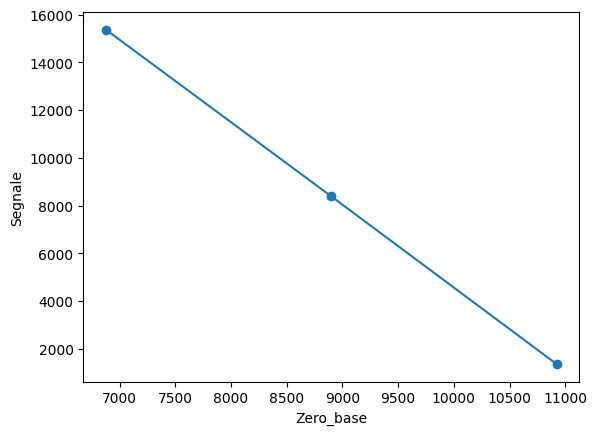

In [10]:
plt.errorbar(zero_base_amb, rad_amb['rad'], yerr= rad_amb['errore'], fmt='o-', ecolor='black', capsize=3, capthick=0.5)
plt.ylabel('Segnale') 
plt.xlabel('Zero_base')

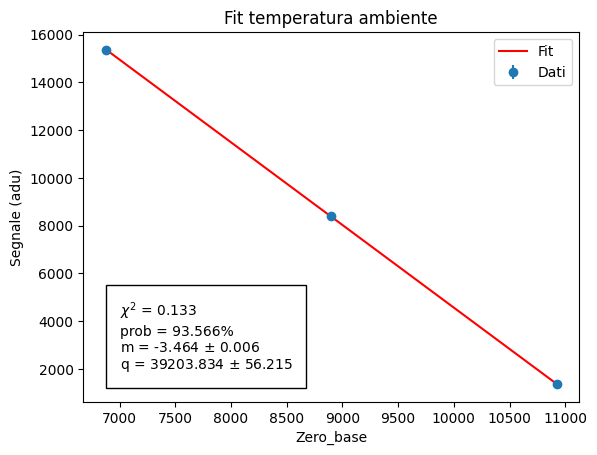

In [11]:
amb = linregress(zero_base_amb,rad_amb['rad']) #x and y are arrays or lists.

chi2 = round(np.sum (((rad_amb['rad'] - amb.intercept - amb.slope*(zero_base_amb))/(rad_amb['errore']))**2),3)

prob = round(stats.chi2.sf(chi2, 2) * 100, 3)  # calcolo probabilità chi quadro

plt.errorbar(zero_base_amb, rad_amb['rad'], yerr= rad_amb['errore'], fmt='o', label='Dati')
plt.plot(zero_base_amb, amb.intercept + amb.slope*(zero_base_amb), 'r-', label='Fit')

chi = '$\chi^2$ = ' + str(chi2) + '\n'
probab = 'prob = ' + str(prob) + '% \n' 
slope = 'm = ' + str(round(amb.slope, 3)) + ' $\pm$ ' + str(round(amb.stderr,3)) + '\n'
intercept = 'q = ' + str(round(amb.intercept, 3)) + ' $\pm$ ' + str(round(amb.intercept_stderr, 3))

plt.text(7000, 2000, chi + probab + slope + intercept, fontsize=10, bbox ={'facecolor':'white', 'pad':10},  color='black')
plt.legend()
plt.ylabel('Segnale (adu)')
plt.xlabel('Zero_base')
plt.title('Fit temperatura ambiente')
plt.show()

## Azoto

            rad     errore
0  16228.785655  33.806212
1  10568.148370  43.639189
2   9189.425021  37.741347
3   1870.828407  33.864818


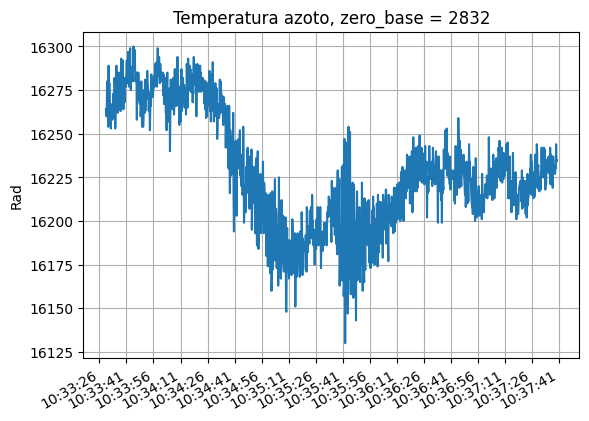

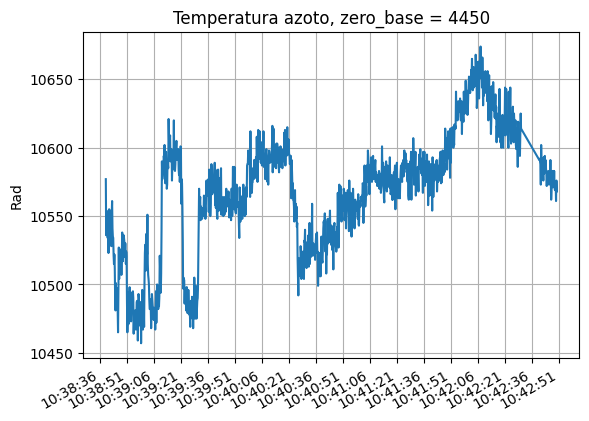

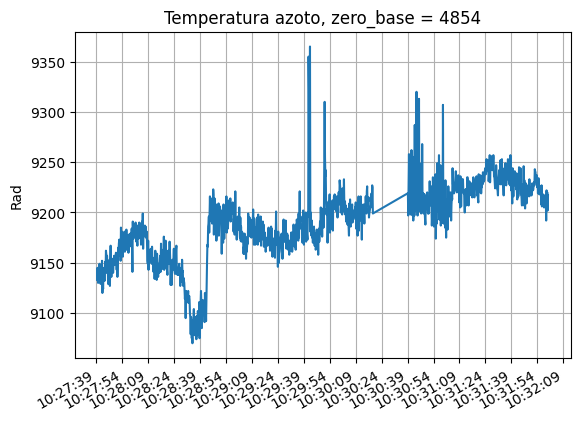

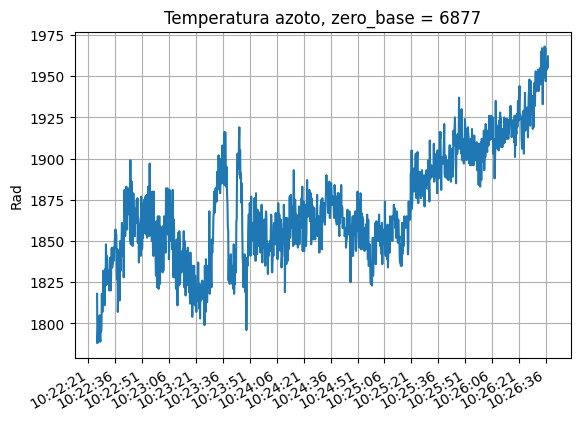

In [12]:
rad_n = []

for i in range(0,4):
    calibrazione_2 = pd.read_csv (files_calibrazione_n[i],
                                    sep = ' ',
                                    header=None,
                                    skiprows=10,
                                    decimal='.',
                                    names=['data','ora','rad','temperatura'])
    
    calibrazione_2['data_ora'] = calibrazione_2['data'].map(str) + ' ' + calibrazione_2['ora'].map(str)
    calibrazione_2['data_ora'] = pd.to_datetime(calibrazione_2['data_ora'], format = '%m/%d/%Y %H:%M:%S.%f')
    calibrazione_2 = calibrazione_2.iloc[:,[-1,2,3]]

    if i == 1:
        mask_5 = calibrazione_2.data_ora <= '2023-04-18 10:42:30'
        mask_6 = calibrazione_2.data_ora >= '2023-04-18 10:42:40'

        calibrazione_2 = calibrazione_2[mask_5 | mask_6]

    if i == 2: 
        mask_3 = calibrazione_2.data_ora <= '2023-04-18 10:30:19'
        mask_4 = calibrazione_2.data_ora >= '2023-04-18 10:30:39'

        calibrazione_2 = calibrazione_2[mask_3 | mask_4]
    
    fig, ax = plt.subplots()
    fig.autofmt_xdate()

    ax.plot(calibrazione_2['data_ora'],calibrazione_2['rad'],  label='temp')
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(SecondLocator(interval = 15))

    plt.title('Temperatura azoto, zero_base = ' + str(zero_base_n[i]))
    plt.grid()
    plt.ylabel('Rad')

    plt.savefig('grafico_n_' + str(i+1))
    
    rad_n.append([calibrazione_2.rad.mean(), calibrazione_2.rad.std()])
    
rad_n = pd.DataFrame(rad_n, columns= ['rad', 'errore'])
print(rad_n)


### Calibrazione azoto

Text(0.5, 0, 'Zero_base')

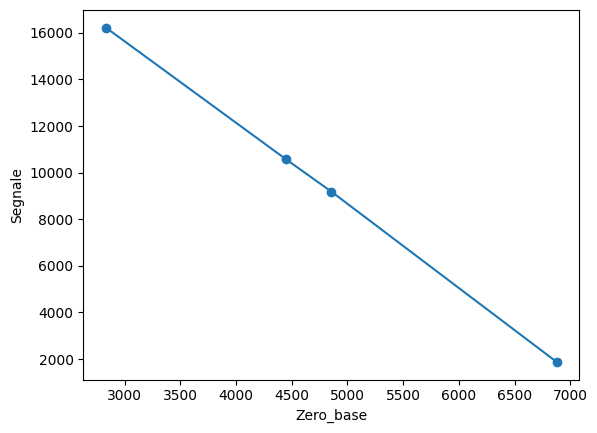

In [13]:
plt.errorbar(zero_base_n, rad_n['rad'], yerr= rad_n['errore'], fmt='o-')
plt.ylabel('Segnale')
plt.xlabel('Zero_base')

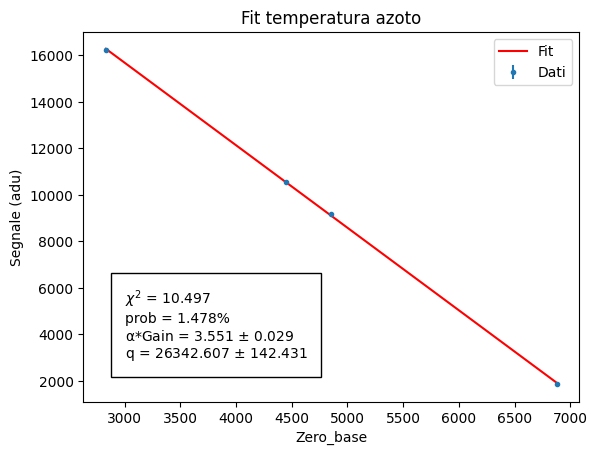

In [40]:
azoto = linregress(zero_base_n,rad_n['rad'])

chi2 = round(np.sum (((rad_n['rad'] - azoto.intercept - azoto.slope*(zero_base_n))/(rad_n['errore']))**2),3)
prob = round(stats.chi2.sf(chi2, 3) * 100, 3)  # calcolo probabilità chi quadro

plt.errorbar(zero_base_n, rad_n['rad'], yerr=rad_n['errore'], fmt='.', label='Dati')
plt.plot(zero_base_n, azoto.intercept + azoto.slope*(zero_base_n), 'r-', label='Fit')

chi = '$\chi^2$ = ' + str(chi2) + '\n'
probab = 'prob = ' + str(prob) + '% \n' 
slope = '\u03B1*Gain = ' + str(-round(azoto.slope, 3)) + ' $\pm$ ' + str(round(azoto.stderr,3)) + '\n'
intercept = 'q = ' + str(round(azoto.intercept, 3)) + ' $\pm$ ' + str(round(azoto.intercept_stderr, 3))
plt.text(3000, 3000, chi + probab + slope + intercept, fontsize=10, bbox ={'facecolor':'white', 'pad':10},  color='black')

plt.title('Fit temperatura azoto')
plt.ylabel('Segnale (adu)')
plt.xlabel('Zero_base')
plt.legend()
plt.show()

## Ricavo gamma

In [15]:
temp_azoto = 77.36 
temp_azoto_err = 0.01

print(media_t_amb)
print(temp_azoto)

293.67101105574596
77.36


In [60]:
# prodotto alpha per Gain(5)
alpha_gain = [[-azoto.slope, azoto.stderr],[-amb.slope, amb.stderr]]
alpha_gain = pd.DataFrame(alpha_gain, columns= ['alpha_gain', 'errore'])
alpha_gain['peso'] = 1/(alpha_gain.errore)**2
print(alpha_gain)

alpha_g = (np.sum(alpha_gain.peso * alpha_gain.alpha_gain))/(np.sum(alpha_gain.peso))  # media alpha * gain
alpha_g_err = 1 / math.sqrt(np.sum(alpha_gain.peso))
print('\u03B1*Gain vale', round(alpha_g,3))
print("L'errore vale", round(alpha_g_err,3))

   alpha_gain    errore          peso
0    3.550899  0.028676   1216.046005
1    3.464336  0.006210  25928.427012
α*Gain vale 3.468
L'errore vale 0.006


In [80]:
num = (amb.intercept - azoto.intercept)
den = (media_t_amb - temp_azoto)

errore_num = math.sqrt((amb.intercept_stderr**2) + (azoto.intercept_stderr**2)) # errore num
errore_den = math.sqrt((media_t_amb_err)**2 + (temp_azoto_err)**2)  # errore den

gamma = num/(84*den)
errore_gamma = (math.sqrt((errore_num/num)**2 + (errore_den/den)**2) * gamma)/84
print('gamma vale', gamma)
print('errore gamma vale', errore_gamma)

gamma vale 0.7078226953227085
errore gamma vale 0.0001007242376323522


## ricavo t_r

In [18]:
t_r_amb = np.array([(rad_amb['rad'] - amb.slope*zero_base_amb)/(84*gamma) - media_t_amb])

In [19]:
t_r_amb

array([[365.57029252, 365.93627868, 365.57029252]])

In [20]:
t_r_n = np.array((rad_n['rad'] - azoto.slope*zero_base_n)/(84*gamma) - temp_azoto)

print(t_r_n)

t_rif = sum(t_r_n)/4 

print('Media della temperatura di riferimento:', t_rif)

[364.72224901 366.14709338 367.08625452 364.81355472]
Media della temperatura di riferimento: 365.69228790658553


In [21]:
t_r_n

array([364.72224901, 366.14709338, 367.08625452, 364.81355472])